In [1]:
import numpy as np
import pandas as pd
import wfdb
from matplotlib import pyplot as plt
from preprocess import *
from sampling import *
from numpy import fft as fft
from sklearn.utils import shuffle
import time
%matplotlib inline

In [2]:
records = wfdb.get_record_list('mitdb')
directory = 'data/'
sample_rate = 360

### Store signals, annotation positions and annotation symbols in dictionaries

In [3]:
# signal data

SignalData = {}

for record in records:    
    signal, field = wfdb.rdsamp(directory + record)
    for channel in [0,1]:
        if field['sig_name'][channel] == 'MLII': # only use data from MLII
            SignalData[record + ' ' + field['sig_name'][channel]] = signal[:, channel]

In [4]:
# annotation data

AnnPos, AnnSym = {}, {}

for record in records:
    annotation = wfdb.rdann(directory + record, 'atr')
    AnnPos[record] = annotation.sample
    AnnSym[record] = annotation.symbol

### Compute segmentation positions
Segmentation positions are the middle points between 2 neighboring beats. They serve as the starting positions of the following beats. For the first beat in a record, the starting position is set to be 0.

In [5]:
SegPos = segmentation(AnnPos) # Segpos is a dictionary that contains all the segmentation data.

### Remove noise from the signal

In [6]:
for key in SignalData.keys():
    
    SignalData[key] = scale(denoise(SignalData[key]))

### Draw samples from the data with a rolling window.

Each sample contains:

1. signals collected in a feature derivation window (FDW)
2. beat annotations in a forecast window (FW)
And there is a time gap between FDW and FW.
The goal is to use 1 to predict 2.

In [16]:
# some parameters
FDW_width, FW_width, gap_width = 25, 1, 0  # widths(in number of beats) of the feature derivation window, forecast window, and the gap in between.
delay = 1 # distance(in number of beats) between two consequential FDWs.
# draw samples
DataSet, LabelSet = rolling_window(SignalData, SegPos, AnnSym, FDW_width, FW_width, gap_width, delay)

In [17]:
print('Number of samples is %d' %(len(DataSet)))
print('Minimum FDW in the samples contains ' + str(min(len(value) for value in DataSet.values())) + ' data points')

Number of samples is 106902
Minimum FDW in the samples contains 2215 data points


In [18]:
print('The last column in each array in DataSet is the patient information')
DataSet[0]

The last column in each array in DataSet is the patient information


array([  2.09938059e-03,   1.42942578e-03,   1.22934721e-03, ...,
        -2.44033613e-02,  -2.42847878e-02,   1.03000000e+02])

### Make the data to be the same lengths: <br>
    Method 1: just crop out the beginning part of the arrays that is longer than the minimum length.

In [19]:
length = 2001
# cropping
for key in DataSet.keys():
    DataSet[key] = DataSet[key][-length:]

### Choose only forecast windows that contains an N or L beat,  downsample N beat, and build X/y matrix as machine learning input/output

In [20]:
# return keys of N and AbNormal beats in the dataset
abnormal_beat_type = ['L','R','B','A','a','J','S','V','r','F','e','j','n','E','P','f','Q']
N_keys = [key for key, value in LabelSet.items() if value == ['N']]
Ab_keys = [key for key, value in LabelSet.items() if value[0] in abnormal_beat_type]
# count numbers of N and L beats in the forecast window
nN, nAb = len(N_keys), len(Ab_keys)
nN, nAb

(73942, 26385)

In [21]:
# build X and y  (note that the last column in X is patient information)
X = np.zeros((nAb * 2, length))
y = np.zeros(nAb * 2)

N_keys_reduced = shuffle(N_keys, n_samples = nAb, random_state = 0) # downsample N beat samples.

i = 0
for key in N_keys_reduced: 
    y[i] = 0
    X[i,:] = DataSet[key]
    i = i + 1
for key in Ab_keys:
    y[i] = 1
    X[i,:] = DataSet[key]
    i = i + 1
X, y = shuffle(X, y, random_state = 0)

In [22]:
Xf = np.zeros((X.shape[0], X.shape[1] + 1))
for i in range(X.shape[0]):
    xf = fft.rfft(X[i,:-1]) # remove the last number in each array that represent patient information.
    Xf[i, 0:(int((X.shape[1] + 1)/2))] = np.real(xf)
    Xf[i, (int((X.shape[1] + 1)/2)):] = np.imag(xf)
Xf = np.append(Xf, X[:,-1][:,None], axis = 1) # add patient information to the last column.

### Split training and testing dataset

In [23]:
X_split, y_split = split_dataset_by_patient(Xf, y, [0.8, 0.2])
X_train, X_test = X_split[0], X_split[1]
y_train, y_test = y_split[0], y_split[1]

### Pipeline

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [24]:
# k-fold cross validation
k = 3
X_partition, y_partition = split_dataset_by_patient(X_train, y_train, np.ones(k)/k)

In [26]:
pipe_nnw = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = 100)),
                     ('clf', MLPClassifier(hidden_layer_sizes = (100,), solver = 'adam', 
                                           random_state = 0, max_iter = 500))])

In [27]:
# Grid search
dim_PCA_list = [200, 500, 1000]
n_layer_list = [(200,), (500,), (200, 20), (500, 20)]
# intialize search result
result={}
result['PCA dimension'] = []
result['hidden layer size'] = []
for i in range(k):
    result['train score ' + str(i)] = []
    result['validation score ' + str(i)] = []
result['validation score mean'] = []
result['validation score std'] = []
result['fitting time mean'] = []

for n_PCA in dim_PCA_list:
    for n_layer in n_layer_list:
        result['PCA dimension'].append(n_PCA)
        result['hidden layer size'].append(n_layer)
        train_score, valid_score = np.zeros(3), np.zeros(3)
        start_time = time.time()
        for i in range(3):    
            valid_part = i
            train_part = [part for part in range(k) if part != valid_part]
            X_train_part = np.concatenate((X_partition[train_part[0]], X_partition[train_part[1]]), axis = 0)[:, :-1]
            X_valid_part = X_partition[valid_part][:, :-1]
            y_train_part = np.concatenate((y_partition[train_part[0]], y_partition[train_part[1]]))
            y_valid_part = y_partition[valid_part]
    
            pipe_nnw.fit(X_train_part, y_train_part)
            train_score[i] = pipe_nnw.score(X_train_part, y_train_part)
            valid_score[i] = pipe_nnw.score(X_valid_part, y_valid_part)
            result['train score ' + str(i)].append(train_score[i])
            result['validation score ' + str(i)].append(valid_score[i])
        fitting_time_mean = (time.time() - start_time) / k
        result['validation score mean'].append(np.mean(valid_score))
        result['validation score std'].append(np.std(valid_score))
        result['fitting time mean'].append(fitting_time_mean)

In [28]:
pd.DataFrame.from_dict(result)

,PCA dimension,fitting time mean,hidden layer size,train score 0,train score 1,train score 2,validation score 0,validation score 1,validation score 2,validation score mean,validation score std
0,200,53.156416,"(200,)",0.908569,0.942135,0.946648,0.557982,0.522424,0.504796,0.528401,0.022121
1,200,40.292270,"(500,)",0.906321,0.937310,0.958606,0.546773,0.528801,0.487505,0.521026,0.024813
2,200,34.727568,"(200, 20)",0.907261,0.933557,0.954544,0.560620,0.530520,0.488136,0.526425,0.029733
3,200,39.448553,"(500, 20)",0.907764,0.948569,0.939404,0.535976,0.517409,0.504481,0.519289,0.012927
4,500,46.325967,"(200,)",0.936250,0.957361,0.961558,0.564081,0.534174,0.495519,0.531258,0.028066
5,500,46.840025,"(500,)",0.901657,0.957683,0.956383,0.556993,0.530377,0.484160,0.523843,0.030091
6,500,31.801303,"(200, 20)",0.896792,0.938025,0.930474,0.544960,0.540264,0.477092,0.520772,0.030946
7,500,48.112543,"(500, 20)",0.948061,0.942242,0.950098,0.566389,0.523356,0.486874,0.525540,0.032499
8,1000,44.148889,"(200,)",0.935680,0.955324,0.958760,0.561691,0.527368,0.483466,0.524175,0.032015
9,1000,43.495678,"(500,)",0.926889,0.949569,0.950941,0.554438,0.523929,0.497791,0.525386,0.023149


In [29]:
patients = {}
for part in range(k):
    patients[part] = np.array(list(set(X_partition[part][:, -1]))).astype(int).astype(str)
    print(part, patients[part])

0 ['228' '233' '106' '203' '107' '112' '114' '116' '215' '217' '124' '223']
1 ['101' '202' '111' '208' '113' '212' '213' '117' '119' '219' '220' '221']
2 ['103' '200' '232' '234' '105' '108' '205' '109' '207' '210' '214' '121']


In [30]:
ann_symbols = pd.DataFrame()

for record in records:
    ann = wfdb.rdann('data/' + record, 'atr')
    ann_symbols[record] = pd.Series(ann.symbol)
ann_counts = ann_symbols.apply(pd.value_counts) 

In [31]:
beat_count = pd.DataFrame()
for part in range(k):
    beat_count['part ' + str(part)] = ann_counts[patients[part]].sum(axis = 1)
beat_count.loc[abnormal_beat_type]

,part 0,part 1,part 2
L,0.0,2123.0,5677.0
R,1531.0,1630.0,483.0
B,NaN,NaN,NaN
A,88.0,161.0,1408.0
a,3.0,25.0,14.0
J,31.0,0.0,50.0
S,0.0,2.0,0.0
V,2722.0,1820.0,1355.0
r,NaN,NaN,NaN
F,33.0,589.0,27.0


In [32]:
pd.options.display.max_columns = None
ann_counts

,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,121,122,123,124,200,201,202,203,205,207,208,209,210,212,213,214,215,217,219,220,221,222,223,228,230,231,232,233,234
!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,427.0,NaN,NaN,NaN
+,1.0,1.0,5.0,1.0,45.0,1.0,41.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,103.0,1.0,1.0,1.0,13.0,111.0,35.0,8.0,37.0,13.0,23.0,35.0,13.0,15.0,1.0,37.0,23.0,3.0,67.0,21.0,17.0,23.0,128.0,23.0,41.0,201.0,11.0,1.0,53.0,3.0
/,NaN,NaN,2028.0,NaN,1353.0,NaN,NaN,2078.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1536.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,33.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2.0,NaN,10.0,NaN,1.0,1.0,92.0,NaN,1.0,NaN,NaN,2.0,16.0,30.0,36.0,NaN,3.0,NaN,NaN,317.0,NaN,NaN,20.0,NaN,3.0,NaN,7.0,94.0,NaN,206.0,61.0,3.0,NaN,1.0,1382.0,6.0,NaN
E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,1.0,NaN,11.0,NaN,316.0,NaN,9.0,NaN,271.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,10.0,NaN
J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0
L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2237.0,2123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1454.0,NaN,NaN,NaN,NaN,NaN,1986.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,2239.0,1860.0,99.0,2082.0,163.0,2135.0,1507.0,NaN,1739.0,NaN,NaN,2261.0,1789.0,1820.0,1953.0,2156.0,1534.0,NaN,1543.0,1861.0,2271.0,1515.0,NaN,1416.0,1625.0,2061.0,1821.0,2178.0,NaN,1145.0,1923.0,2063.0,633.0,1790.0,NaN,2147.0,244.0,2046.0,1954.0,1849.0,1712.0,1757.0,1688.0,2070.0,314.0,NaN,1625.0,2211.0


### Try mixed patient data

split training and testing data

In [73]:
test_ratio = 0.2
test_num = int(test_ratio * X.shape[0])
X, y = shuffle(X, y, random_state = 0)
Xmix_test, ymix_test = X[0:test_num, :-1], y[0:test_num]
Xmix_train, ymix_train = X[test_num:, :-1], y[test_num:]

Grid Search

In [34]:
pipe_nnw = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = n_PCA)),
                     ('clf', MLPClassifier(hidden_layer_sizes = n_layer, solver = 'adam', 
                                           random_state = 0, max_iter = 500))])

In [35]:
grid_params = [{'pca__n_components': [200, 500, 1000], 
              'clf__hidden_layer_sizes': [(200,), (500,), (200, 20), (500, 20)]}]
gs = GridSearchCV(estimator = pipe_nnw, param_grid = grid_params, scoring = 'accuracy', cv = 3)
gs.fit(Xmix_train, ymix_train)

print('Best accuracy: %.3f' % gs.best_score_)
print('\nBest params:\n', gs.best_params_)

Best accuracy: 0.887

Best params:
 {'clf__hidden_layer_sizes': (500, 20), 'pca__n_components': 200}


In [36]:
pd.DataFrame.from_dict(gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__hidden_layer_sizes,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,34.025161,2.790901,0.872963,0.991330,"(200,)",200,"{'clf__hidden_layer_sizes': (200,), 'pca__n_co...",10,0.879974,0.996305,0.868462,0.987884,0.870452,0.989802,0.757360,0.148230,0.005024,0.003604
1,53.005277,3.208782,0.872371,0.993853,"(200,)",500,"{'clf__hidden_layer_sizes': (200,), 'pca__n_co...",11,0.876919,0.997726,0.868249,0.989305,0.871944,0.994528,1.023183,0.023148,0.003552,0.003471
2,141.102883,3.888506,0.883551,1.000000,"(200,)",1000,"{'clf__hidden_layer_sizes': (200,), 'pca__n_co...",2,0.887081,1.000000,0.881964,1.000000,0.881609,1.000000,4.418978,0.032248,0.002500,0.000000
3,36.016150,2.872713,0.875569,0.987682,"(500,)",200,"{'clf__hidden_layer_sizes': (500,), 'pca__n_co...",7,0.874716,0.987457,0.875213,0.984224,0.876777,0.991366,1.292310,0.025514,0.000878,0.002920
4,63.678083,3.320373,0.876540,0.994647,"(500,)",500,"{'clf__hidden_layer_sizes': (500,), 'pca__n_co...",6,0.875995,0.995630,0.880401,0.995239,0.873223,0.993071,1.977505,0.014759,0.002955,0.001125
5,156.550767,4.245205,0.874692,0.993427,"(500,)",1000,"{'clf__hidden_layer_sizes': (500,), 'pca__n_co...",8,0.872442,0.993000,0.864838,0.987280,0.886796,1.000000,35.038580,0.062582,0.009105,0.005202
6,31.510384,2.482035,0.878861,0.995298,"(200, 20)",200,"{'clf__hidden_layer_sizes': (200, 20), 'pca__n...",4,0.882817,1.000000,0.877700,0.994102,0.876066,0.991792,5.600510,0.466649,0.002876,0.003456
7,43.396454,2.745117,0.871447,0.991532,"(200, 20)",500,"{'clf__hidden_layer_sizes': (200, 20), 'pca__n...",12,0.876066,0.991543,0.870310,0.990406,0.867965,0.992645,1.328036,0.641346,0.003404,0.000914
8,108.937619,4.836014,0.874147,0.993083,"(200, 20)",1000,"{'clf__hidden_layer_sizes': (200, 20), 'pca__n...",9,0.876421,0.994848,0.870523,0.991970,0.875497,0.992432,11.369960,1.275142,0.002590,0.001262
9,173.728426,3.853611,0.886678,0.991887,"(500, 20)",200,"{'clf__hidden_layer_sizes': (500, 20), 'pca__n...",1,0.890847,0.992716,0.883883,0.986711,0.885304,0.996234,166.021277,0.705680,0.003005,0.003931


Model with best parameters

In [74]:
pipe_nnw = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = 200)),
                     ('clf', MLPClassifier(hidden_layer_sizes = (500,), solver = 'adam', 
                                           random_state = 0, max_iter = 500))])
pipe_nnw.fit(Xmix_train, ymix_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

In [75]:
print('Test score is %.3f' %pipe_nnw.score(Xmix_test, ymix_test))

Test score is 0.892


In [76]:
ymix_preds = pipe_nnw.predict_proba(Xmix_test)[:, 1]
fpr0, tpr0, threshold = metrics.roc_curve(ymix_test, ymix_preds)

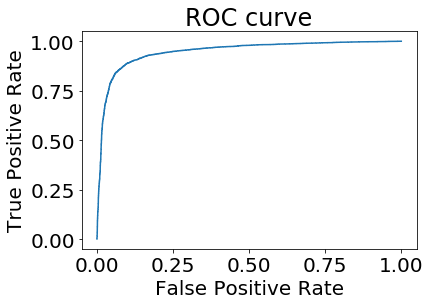

In [79]:
plt.rc('font', size = 20)
plt.plot(fpr0,tpr0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

### Predict next beat
gap_width  = 1

In [77]:
X_train, y_train, X_test, y_test = build_data_matrix(SignalData, SegPos, AnnSym, 
                                                     FDW_width = 25, FW_width = 1, gap_width = 1, delay = 1)

Test score is 0.830


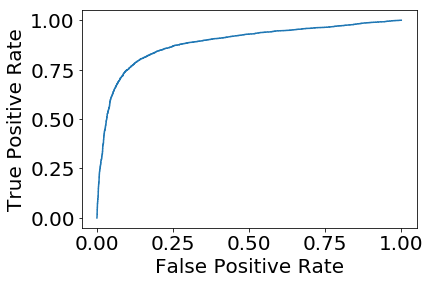

In [78]:
pipe_nnw = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = 200)),
                     ('clf', MLPClassifier(hidden_layer_sizes = (500,), solver = 'adam', 
                                           random_state = 0, max_iter = 500))])
pipe_nnw.fit(X_train, y_train)
print('Test score is %.3f' %pipe_nnw.score(X_test, y_test))
y_preds = pipe_nnw.predict_proba(X_test)[:, 1]
fpr1, tpr1, threshold = metrics.roc_curve(y_test, y_preds)
plt.plot(fpr1,tpr1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Predict the 3rd beat
gap_width  = 2

In [130]:
X_train, y_train, X_test, y_test = build_data_matrix(SignalData, SegPos, AnnSym, 
                                                     FDW_width = 25, FW_width = 1, gap_width = 2, delay = 1)

Test score is 0.808


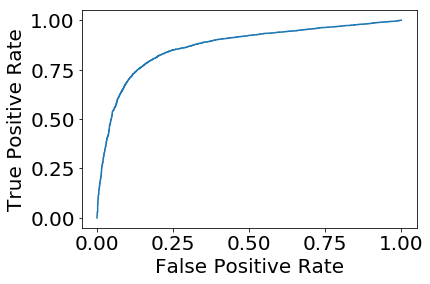

In [131]:
pipe_nnw = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = 200)),
                     ('clf', MLPClassifier(hidden_layer_sizes = (500,), solver = 'adam', 
                                           random_state = 0, max_iter = 500))])
pipe_nnw.fit(X_train, y_train)
print('Test score is %.3f' %pipe_nnw.score(X_test, y_test))
y_preds = pipe_nnw.predict_proba(X_test)[:, 1]
fpr2, tpr2, threshold = metrics.roc_curve(y_test, y_preds)
plt.plot(fpr2,tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Predict the 4th beat
gap_width = 3

Test score is 0.781


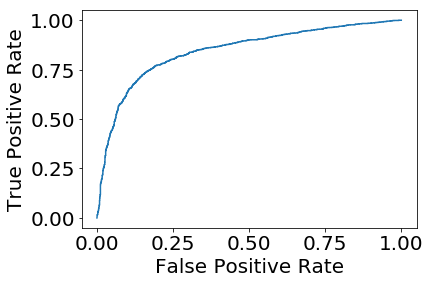

In [83]:
pipe_nnw = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = 200)),
                     ('clf', MLPClassifier(hidden_layer_sizes = (500,), solver = 'adam', 
                                           random_state = 0, max_iter = 500))])
pipe_nnw.fit(X_train, y_train)
print('Test score is %.3f' %pipe_nnw.score(X_test, y_test))
y_preds = pipe_nnw.predict_proba(X_test)[:, 1]
fpr3, tpr3, threshold = metrics.roc_curve(y_test, y_preds)
plt.plot(fpr3,tpr3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Predict the 5th beat
gap_width = 4

In [133]:
X_train, y_train, X_test, y_test = build_data_matrix(SignalData, SegPos, AnnSym, 
                                                     FDW_width = 25, FW_width = 1, gap_width = 3, delay = 1)

Test score is 0.794


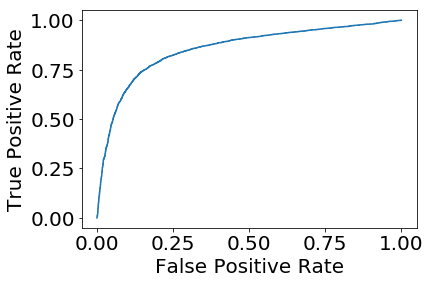

In [140]:
pipe_nnw = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = 200)),
                     ('clf', MLPClassifier(hidden_layer_sizes = (50,), solver = 'adam', 
                                           random_state = 0, max_iter = 200))])
pipe_nnw.fit(X_train, y_train)
print('Test score is %.3f' %pipe_nnw.score(X_test, y_test))
y_preds = pipe_nnw.predict_proba(X_test)[:, 1]
fpr5, tpr5, threshold = metrics.roc_curve(y_test, y_preds)
plt.plot(fpr5,tpr5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Testing accuracy vs forecasting beat position

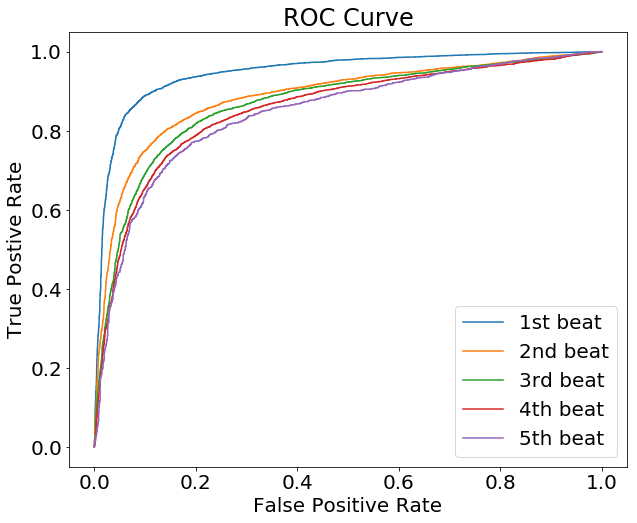

In [144]:
plt.figure(figsize=(10, 8))
plt.plot(fpr0, tpr0, label = '1st beat')
plt.plot(fpr1, tpr1, label = '2nd beat')
plt.plot(fpr2, tpr2, label = '3rd beat')
plt.plot(fpr5, tpr5, label = '4th beat')
plt.plot(fpr3, tpr3, label = '5th beat')
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC Curve')

plt.legend()

([<matplotlib.axis.XTick at 0x1259931d0>,
 <a list of 5 Text xticklabel objects>)

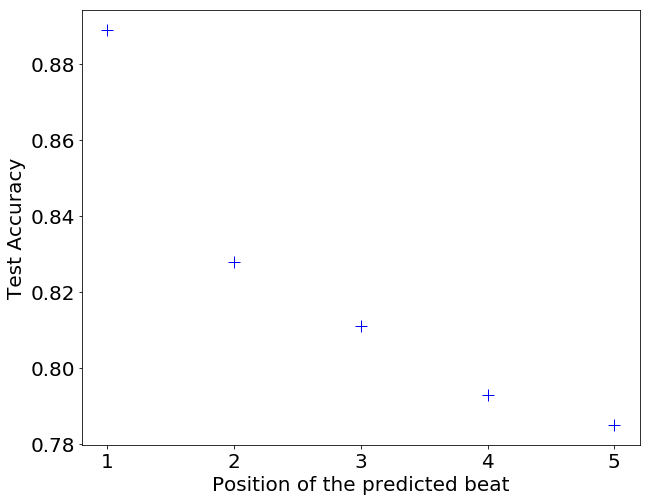

In [67]:
score_series = [0.889, 0.828, 0.811, 0.793, 0.785]
position = np.arange(5) + 1
plt.figure(figsize=(10, 8))
plt.plot(position, score_series, 'b+', linewidth=2, markersize=12)
plt.xlabel('Position of the predicted beat')
plt.ylabel('Test Accuracy')
plt.xticks(position, [1, 2, 3, 4, 5])